# Differentiable Simulation

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/03-diffsim/diffsim-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/03-diffsim/diffsim.ipynb)

**Slides:** [![View PDF](https://img.shields.io/badge/View-PDF-red?style=flat-square&logo=googledocs&logoColor=white)](https://github.com/kks32-courses/sciml/raw/main/docs/03-diffsim/diffsim-slides.pdf)

In the [previous MLP notebook](../01-mlp/mlp), we introduced Automatic Differentiation (AD) as the core engine that enables the training of neural networks by computing gradients of a loss function with respect to network parameters. 

However, the power of AD extends far beyond just neural networks. It allows us to make **entire physical simulations differentiable**. This paradigm, often called **Differentiable Simulation** or **Differentiable Physics**, involves implementing a simulator (e.g., a PDE solver) in a framework that supports AD, such as PyTorch or JAX. By doing so, we can automatically compute the gradient of a final quantity (like a measurement or a loss function) with respect to any initial parameter of the simulation.

This notebook demonstrates this powerful concept. We will:
1. Briefly recall how gradients are computed in PyTorch.
2. Introduce the JAX framework for high-performance differentiable programming.
3. Build a differentiable simulator for the 1D acoustic wave equation.
4. Use this simulator to solve a challenging inverse problem: Full Waveform Inversion (FWI).

## What is Differentiable Simulation?

Differentiable simulation combines physics-based simulation with automatic differentiation to solve **inverse problems**.

Instead of:
- **Forward Problem**: Given parameters → predict observations
- **Traditional Inverse**: Trial-and-error parameter search

We use:
- **Differentiable Simulation**: Compute gradients through simulation → gradient-based optimization

**Key insight**: If we can compute $\frac{\partial \text{simulation}}{\partial \text{parameters}}$, we can use gradient descent to find optimal parameters.

## From PyTorch to JAX: A Quick Review

We introduced automatic differentiation in the MLP module. 


As we saw previously, frameworks like PyTorch keep track of all operations on tensors. When we call `.backward()` on a final scalar output (like a loss), PyTorch uses reverse-mode AD (backpropagation) to compute the gradient of that output with respect to the inputs that have `requires_grad=True`. Here's a quick recap of computing gradients in PyTorch:

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Simple function: loss = (prediction - target)^2
def simple_loss(params, target):
    prediction = params[0] * 2.0 + params[1]  # ax + b
    return (prediction - target)**2

# PyTorch gradient computation
params = torch.tensor([1.0, 0.5], requires_grad=True)
target = 5.0

loss = simple_loss(params, target)
loss.backward()

print(f"Loss: {loss.item():.4f}")
print(f"Gradients: {params.grad}")
print(f"Parameters: {params.detach()}")

Loss: 6.2500
Gradients: tensor([-10.,  -5.])
Parameters: tensor([1.0000, 0.5000])


## JAX: The Scientific Computing Advantage

JAX provides several advantages for scientific computing:
- **Functional programming**: Pure functions, no side effects
- **JIT compilation**: Fast execution with `jit`
- **Vectorization**: Automatic batching with `vmap`
- **Transformations**: `grad`, `jit`, `vmap` compose seamlessly

Same computation in JAX:

In [7]:
!pip install -q jax jaxlib optax tensorflow-probability

/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import optax
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

# Same function in JAX
def simple_loss_jax(params, target):
    prediction = params[0] * 2.0 + params[1]
    return (prediction - target)**2

# JAX gradient computation
params_jax = jnp.array([1.0, 0.5])
target_jax = 5.0

# Create gradient function



loss_val = simple_loss_jax(params_jax, target_jax)
gradients = grad_fn(params_jax, target_jax)

print(f"Loss: {loss_val:.4f}")
print(f"Gradients: {gradients}")
print(f"Parameters: {params_jax}")

Loss: 6.2500
Gradients: [-10.  -5.]
Parameters: [1.  0.5]


In [ ]:
import jax.numpy as jnp
from jax import jit, grad
import time

# Complex polynomial operation
def f(x):
    return x**4 - 3*x**3 + 2*x**2 - x + 1

# JIT version
## Add jit <<--HERE------
def fast_f(x):
    return x**4 - 3*x**3 + 2*x**2 - x + 1

# Large array
x = jnp.linspace(-10, 10, 1_000_000)

# Time without JIT
start = time.time()
result1 = f(x)
time_no_jit = time.time() - start

# Time with JIT (includes compilation on first run)
start = time.time()
result2 = fast_f(x)
time_with_jit = time.time() - start

# Time JIT on second run (no compilation)
start = time.time()
result3 = fast_f(x)
time_jit_second = time.time() - start

print(f"No JIT: {time_no_jit:.4f}s")
print(f"JIT (first run): {time_with_jit:.4f}s")
print(f"JIT (second run): {time_jit_second:.4f}s")
print(f"Speedup: {time_no_jit/time_jit_second:.2f}x")

# Gradient example



print(f"Gradient at x=1.0: {df(1.0)}")
print(f"JIT gradient at x=1.0: {fast_df(1.0)}")

No JIT: 0.0004s
JIT (first run): 0.0207s
JIT (second run): 0.0001s
Speedup: 3.11x
Gradient at x=1.0: -2.0
JIT gradient at x=1.0: -2.0


## JAX Transformations: The Power of Composition

JAX's key advantage is that transformations compose. You can combine `grad`, `jit`, and `vmap` in any order:

In [ ]:
# vmap example - scalar function that needs vectorization
from jax import vmap

def scalar_only_func(x):
    """Function that only works on scalars"""
    return jnp.where(x > 0, x**2, -x**3)

# This would fail on array: scalar_only_func(x)
# Need vmap to vectorize it
vectorized_func =
jit_vectorized_func = 

# Test on smaller array
small_x = jnp.array([-2.0, -1.0, 0.0, 1.0, 2.0])
result_vmap = vectorized_func(small_x)
result_jit_vmap = jit_vectorized_func(small_x)

print(f"vmap result: {result_vmap}")
print(f"jit+vmap result: {result_jit_vmap}")

vmap result: [ 8.  1. -0.  1.  4.]
jit+vmap result: [ 8.  1. -0.  1.  4.]


## The 1D Wave Equation: Our Physics Model

Let's implement a differentiable physics simulation. We'll use the 1D acoustic wave equation:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

Where:
- $u(x,t)$ is the wavefield (pressure/displacement)
- $c(x)$ is the wave speed (what we want to estimate)

**Finite difference discretization**:
$$u_{i}^{n+1} = 2u_{i}^{n} - u_{i}^{n-1} + \frac{c_i^2 \Delta t^2}{\Delta x^2}(u_{i+1}^{n} - 2u_{i}^{n} + u_{i-1}^{n})$$

**Initial conditions**: Gaussian source
$$u_0 = \exp\left(-5(x - 0.5)^2\right)$$


### The Forward Problem: Simulation
The forward problem is to simulate the behavior of $u(x,t)$ given an initial state and the wave speed profile $c(x)$. We will solve this using a finite difference method. By rearranging the central difference approximation, we can find the wave's state at the next timestep based on its two previous states:

$$u_i^{n+1} = c_i^2 \frac{\Delta t^2}{\Delta x^2} (u_{i+1}^n - 2u_i^n + u_{i-1}^n) + 2u_i^n - u_i^{n-1} $$

We can implement this time-stepping loop in JAX. Using `@jit`, this loop will be compiled for high performance.

![FWI](figs/1dfwi.png)

In [ ]:
# Set up the wave equation solver
n = 1000  # Number of spatial points
dx = 1.0 / (n - 1)
x0 = jnp.linspace(0.0, 1.0, n)

@jit
def wave_propagation(params):
    """Solve 1D wave equation using finite differences"""
    c = params  # Velocity model
    dt = 5e-4   # Time step
    
    # CFL condition check: C = c*dt/dx should be < 1
    C = c * dt / dx
    C2 = C * C
    
    # Initial conditions: Gaussian source
    u0 = jnp.exp(-(5 * (x0 - 0.5))**2)
    u1 = jnp.exp(-(5 * (x0 - 0.5 - c * dt))**2)
    u2 = jnp.zeros(n)
    
    def step(i, carry):
        u0, u1, u2 = carry
        
        # Boundary conditions: u = 0 at boundaries
                                                # u[j-1]
                                                # u[j+1]
        
        # Central difference scheme
      
        
        # Update for next iteration
        u0 = u1
        u1 = u2
        return (u0, u1, u2)
    
    # Time stepping: 5000 steps
    
    
    return u2

print("Wave propagation solver defined successfully!")
print(f"Grid points: {n}")
print(f"Spatial step: {dx:.6f}")
print(f"Time step: {5e-4}")

Wave propagation solver defined successfully!
Grid points: 1000
Spatial step: 0.001001
Time step: 0.0005


## Example 1: Constant Velocity Recovery

**The Problem**: Given observed wavefield data, can we recover a constant velocity?

- **Target**: $c = 1.0$ (constant)
- **Initial guess**: $c = 0.8$ 
- **Goal**: Use gradients to optimize $c$ until simulation matches observations

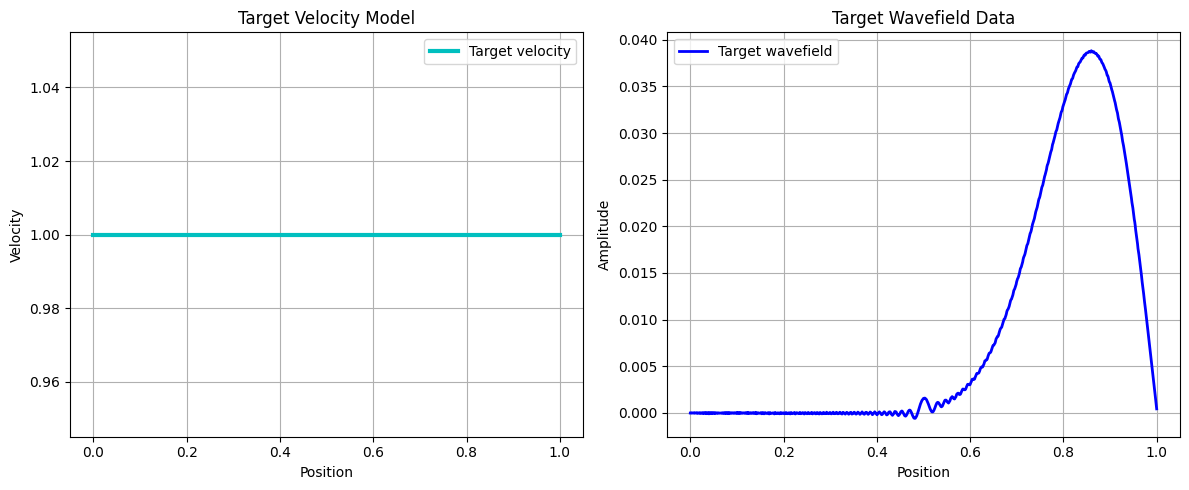

Target velocity: 1.0
Target data shape: (1000,)


In [12]:
# Generate synthetic observed data
ctarget = 1.0  # True constant velocity
target_data = wave_propagation(ctarget)

# Visualize target
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x0, jnp.ones(n) * ctarget, 'c-', linewidth=3, label='Target velocity')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Target Velocity Model')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x0, target_data, 'b-', linewidth=2, label='Target wavefield')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.title('Target Wavefield Data')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Target velocity: {ctarget}")
print(f"Target data shape: {target_data.shape}")

In [ ]:
# Define loss function for constant velocity inversion
@jit
def compute_loss_constant(c_scalar):
    """Loss function for constant velocity model"""
    # Convert scalar to constant array
    c_array = jnp.ones(n) * c_scalar
    u2 = wave_propagation(c_array)
    return jnp.linalg.norm(u2 - target_data)

# Gradient function
grad_loss_constant = 


# Initial guess
c_initial = 0.8
print(f"Initial guess: {c_initial}")
print(f"Target: {ctarget}")
print(f"Initial loss: {compute_loss_constant(c_initial):.6f}")

Initial guess: 0.8
Target: 1.0
Initial loss: 15.758533


In [14]:
# Optimize constant velocity using Adam
def optax_adam_constant(c_init, niter):
    """Optimize constant velocity using Adam optimizer"""
    start_learning_rate = 1e-3
    optimizer = optax.adam(start_learning_rate)
    c_param = c_init
    opt_state = optimizer.init(c_param)
    
    losses = []
    
    for i in range(niter):
        loss_val = compute_loss_constant(c_param)
        grads = grad_loss_constant(c_param)
        
        updates, opt_state = optimizer.update(grads, opt_state)
        c_param = optax.apply_updates(c_param, updates)
        
        losses.append(loss_val)
        
        if i % 200 == 0:
            print(f"Iteration {i:4d}: Loss = {loss_val:.6f}, Velocity = {c_param:.6f}")
    
    return c_param, losses

# Run optimization
print("Starting constant velocity optimization...")
c_optimized, losses = optax_adam_constant(c_initial, 1000)

print(f"\nOptimization Results:")
print(f"Initial velocity: {c_initial:.6f}")
print(f"Target velocity:  {ctarget:.6f}")
print(f"Final velocity:   {c_optimized:.6f}")
print(f"Error:           {abs(c_optimized - ctarget):.6f}")
print(f"Loss reduction:   {losses[0]/losses[-1]:.1f}x")

Starting constant velocity optimization...
Iteration    0: Loss = 15.758533, Velocity = 0.801000
Iteration  200: Loss = 0.039644, Velocity = 1.000228
Iteration  400: Loss = 0.021305, Velocity = 1.000039
Iteration  600: Loss = 0.021443, Velocity = 1.000031
Iteration  800: Loss = 0.017808, Velocity = 1.000041

Optimization Results:
Initial velocity: 0.800000
Target velocity:  1.000000
Final velocity:   0.999937
Error:           0.000063
Loss reduction:   840.8x


## Example 2: Linear profile

![FWI gif](figs/fwi.gif)

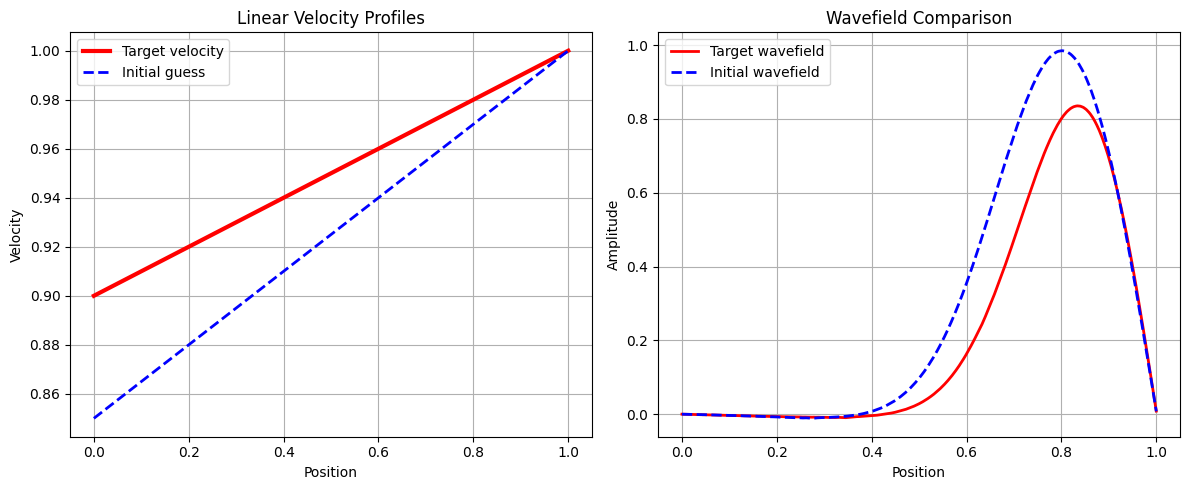

Target velocity range: [0.900, 1.000]
Initial guess range:    [0.850, 1.000]
Number of parameters to optimize: 1000


In [15]:
# Generate synthetic data for linear velocity profile
ctarget_linear = jnp.linspace(0.9, 1.0, n)  # Target: linear increase
target_linear = wave_propagation(ctarget_linear)

# Initial guess: different linear profile
c_initial_linear = jnp.linspace(0.85, 1.0, n)

# Define loss function for linear velocity profile
@jit
def compute_loss_linear(c_array):
    """Loss function for spatially-varying velocity model"""
    u2 = wave_propagation(c_array)
    return jnp.linalg.norm(u2 - target_linear)

# Gradient function
grad_loss_linear = jit(grad(compute_loss_linear))

# Visualize setup
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x0, ctarget_linear, 'r-', linewidth=3, label='Target velocity')
plt.plot(x0, c_initial_linear, 'b--', linewidth=2, label='Initial guess')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Linear Velocity Profiles')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
target_init_linear = wave_propagation(c_initial_linear)
plt.plot(x0, target_linear, 'r-', linewidth=2, label='Target wavefield')
plt.plot(x0, target_init_linear, 'b--', linewidth=2, label='Initial wavefield')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.title('Wavefield Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Target velocity range: [{jnp.min(ctarget_linear):.3f}, {jnp.max(ctarget_linear):.3f}]")
print(f"Initial guess range:    [{jnp.min(c_initial_linear):.3f}, {jnp.max(c_initial_linear):.3f}]")
print(f"Number of parameters to optimize: {len(c_initial_linear)}")

# Test initial loss and gradient to verify everything is working
initial_loss_linear = compute_loss_linear(c_initial_linear)
initial_grad_linear = grad_loss_linear(c_initial_linear)

print(f"Initial loss: {initial_loss_linear:.6f}")
print(f"Gradient shape: {initial_grad_linear.shape}")
print(f"Gradient norm: {jnp.linalg.norm(initial_grad_linear):.6f}")
print(f"Gradient range: [{jnp.min(initial_grad_linear):.6f}, {jnp.max(initial_grad_linear):.6f}]")

In [16]:
# Optimizers for linear profile
def optax_adam_linear(params, niter):
    """Optimize spatially-varying velocity using Adam optimizer"""
    start_learning_rate = 1e-3
    optimizer = optax.adam(start_learning_rate)
    opt_state = optimizer.init(params)
    
    for i in range(niter):
        grads = grad_loss_linear(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        if i % 200 == 0:
            loss_val = compute_loss_linear(params)
            velocity_rmse = jnp.sqrt(jnp.mean((params - ctarget_linear)**2))
            print(f"Iteration {i:4d}: Loss = {loss_val:.6f}, Velocity RMSE = {velocity_rmse:.6f}")
    
    return params

def tfp_lbfgs_linear(params):
    """Optimize using L-BFGS"""
    # For TFP L-BFGS, we need a function that returns both value and gradients
    from jax import value_and_grad
    
    value_and_grad_fn = jit(value_and_grad(compute_loss_linear))
    
    results = tfp.optimizer.lbfgs_minimize(
        value_and_grad_fn, 
        initial_position=params, 
        tolerance=1e-5
    )
    return results.position

# Initial and Target 
c_initial_linear = jnp.linspace(0.85, 1.0, n)
ctarget_linear = jnp.linspace(0.9, 1.0, n)

# Run Adam optimization
print("Starting Adam optimization...")
result_adam = optax_adam_linear(c_initial_linear, 1000)

# Run L-BFGS optimization
print("\nStarting L-BFGS optimization...")
result_lbfgs = tfp_lbfgs_linear(c_initial_linear)

# Compare results
adam_rmse = jnp.sqrt(jnp.mean((result_adam - ctarget_linear)**2))
lbfgs_rmse = jnp.sqrt(jnp.mean((result_lbfgs - ctarget_linear)**2))

print(f"\nFinal Results:")
print(f"Adam RMSE:   {adam_rmse:.8f}")
print(f"L-BFGS RMSE: {lbfgs_rmse:.8f}")
print(f"L-BFGS improvement: {adam_rmse/lbfgs_rmse:.1f}x better")

Starting Adam optimization...
Iteration    0: Loss = 3.807940, Velocity RMSE = 0.028013
Iteration  200: Loss = 0.008648, Velocity RMSE = 0.015287
Iteration  400: Loss = 0.021045, Velocity RMSE = 0.016096
Iteration  600: Loss = 0.014158, Velocity RMSE = 0.016653
Iteration  800: Loss = 0.029612, Velocity RMSE = 0.016825

Starting L-BFGS optimization...

Final Results:
Adam RMSE:   0.01696190
L-BFGS RMSE: 0.01419833
L-BFGS improvement: 1.2x better


In [17]:
# Define loss function for linear velocity profile
@jit
def compute_loss_linear(c_array):
    """Loss function for spatially-varying velocity model"""
    u2 = wave_propagation(c_array)
    return jnp.linalg.norm(u2 - target_linear)

# Gradient function
grad_loss_linear = jit(grad(compute_loss_linear))

# Test initial loss and gradient
initial_loss_linear = compute_loss_linear(c_initial_linear)
initial_grad_linear = grad_loss_linear(c_initial_linear)

print(f"Initial loss: {initial_loss_linear:.6f}")
print(f"Gradient shape: {initial_grad_linear.shape}")
print(f"Gradient norm: {jnp.linalg.norm(initial_grad_linear):.6f}")

Initial loss: 3.944904
Gradient shape: (1000,)
Gradient norm: 4.976274


In [18]:
# Optimizers for linear profile
def optax_adam_linear(params, niter):
    """Optimize spatially-varying velocity using Adam optimizer"""
    start_learning_rate = 1e-3
    optimizer = optax.adam(start_learning_rate)
    opt_state = optimizer.init(params)
    
    for i in range(niter):
        grads = grad_loss_linear(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        if i % 200 == 0:
            loss_val = compute_loss_linear(params)
            velocity_rmse = jnp.sqrt(jnp.mean((params - ctarget_linear)**2))
            print(f"Iteration {i:4d}: Loss = {loss_val:.6f}, Velocity RMSE = {velocity_rmse:.6f}")
    
    return params

def tfp_lbfgs_linear(params):
    """Optimize using L-BFGS"""
    # For TFP L-BFGS, we need a function that returns both value and gradients
    from jax import value_and_grad
    
    value_and_grad_fn = jit(value_and_grad(compute_loss_linear))
    
    results = tfp.optimizer.lbfgs_minimize(
        value_and_grad_fn, 
        initial_position=params, 
        tolerance=1e-5
    )
    return results.position

# Run Adam optimization
print("Starting Adam optimization...")
result_adam = optax_adam_linear(c_initial_linear, 1000)

# Run L-BFGS optimization
print("\nStarting L-BFGS optimization...")
result_lbfgs = tfp_lbfgs_linear(c_initial_linear)

# Compare results
adam_rmse = jnp.sqrt(jnp.mean((result_adam - ctarget_linear)**2))
lbfgs_rmse = jnp.sqrt(jnp.mean((result_lbfgs - ctarget_linear)**2))

print(f"\nFinal Results:")
print(f"Adam RMSE:   {adam_rmse:.8f}")
print(f"L-BFGS RMSE: {lbfgs_rmse:.8f}")
print(f"L-BFGS improvement: {adam_rmse/lbfgs_rmse:.1f}x better")

Starting Adam optimization...
Iteration    0: Loss = 3.807940, Velocity RMSE = 0.028013
Iteration  200: Loss = 0.008648, Velocity RMSE = 0.015287
Iteration  400: Loss = 0.021045, Velocity RMSE = 0.016096
Iteration  600: Loss = 0.014158, Velocity RMSE = 0.016653
Iteration  800: Loss = 0.029612, Velocity RMSE = 0.016825

Starting L-BFGS optimization...

Final Results:
Adam RMSE:   0.01696190
L-BFGS RMSE: 0.01419833
L-BFGS improvement: 1.2x better


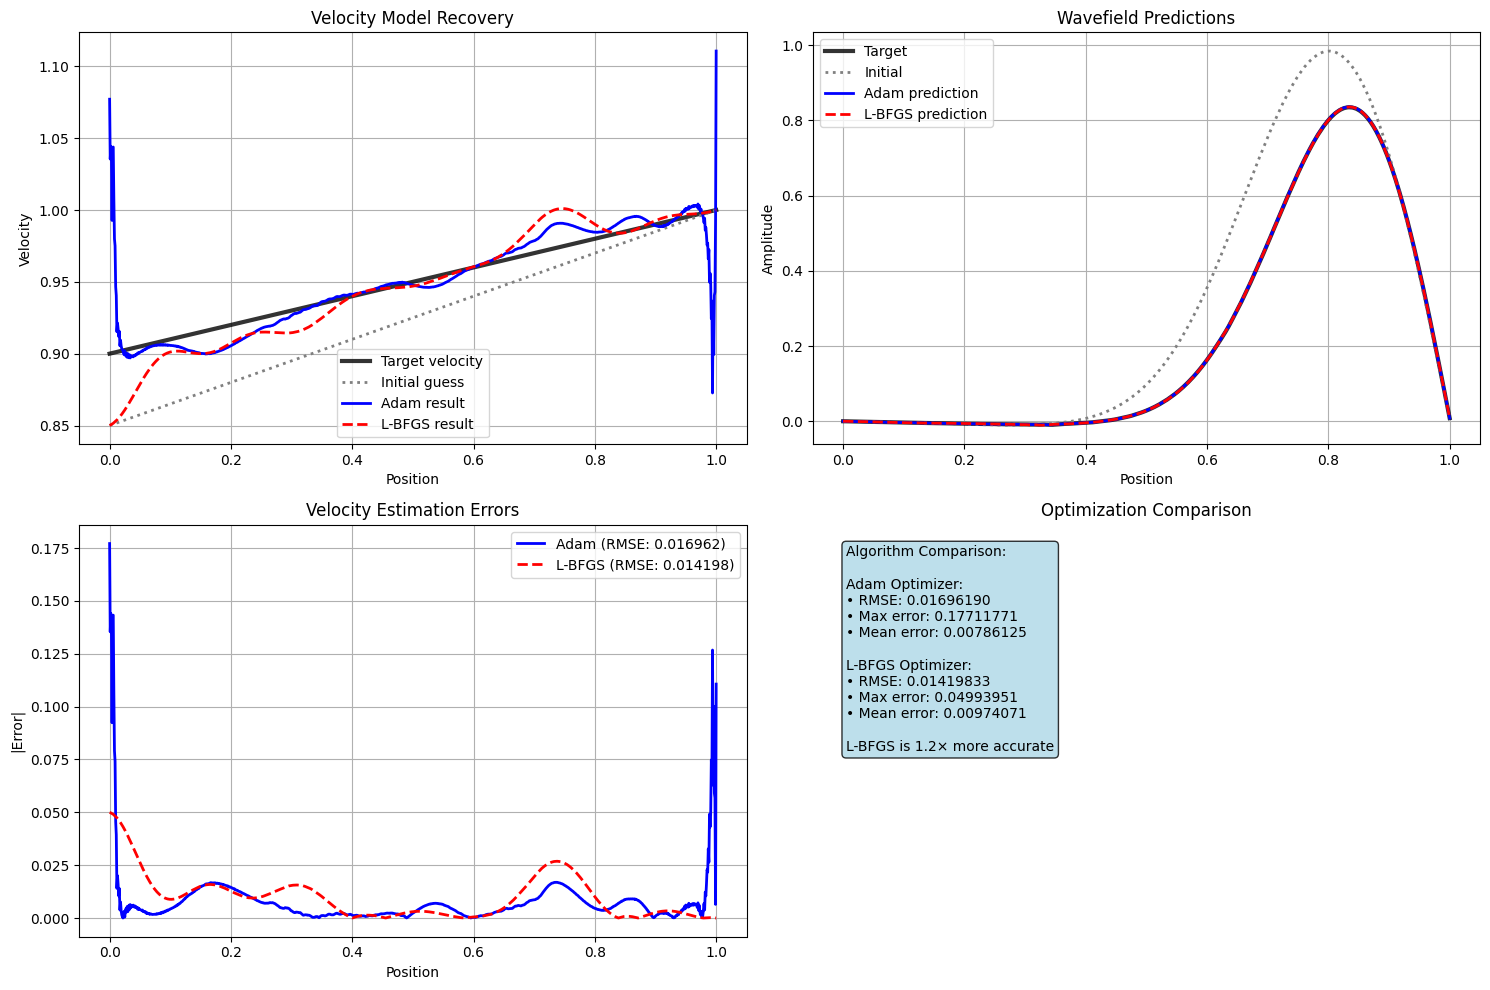

In [19]:
# Visualize linear velocity optimization results
wave_adam = wave_propagation(result_adam)
wave_lbfgs = wave_propagation(result_lbfgs)
wave_initial = wave_propagation(c_initial_linear)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Velocity model comparison
axes[0, 0].plot(x0, ctarget_linear, 'k-', linewidth=3, label='Target velocity', alpha=0.8)
axes[0, 0].plot(x0, c_initial_linear, 'gray', linestyle=':', linewidth=2, label='Initial guess')
axes[0, 0].plot(x0, result_adam, 'b-', linewidth=2, label='Adam result')
axes[0, 0].plot(x0, result_lbfgs, 'r--', linewidth=2, label='L-BFGS result')
axes[0, 0].set_xlabel('Position')
axes[0, 0].set_ylabel('Velocity')
axes[0, 0].set_title('Velocity Model Recovery')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Wavefield comparison
axes[0, 1].plot(x0, target_linear, 'k-', linewidth=3, label='Target', alpha=0.8)
axes[0, 1].plot(x0, wave_initial, 'gray', linestyle=':', linewidth=2, label='Initial')
axes[0, 1].plot(x0, wave_adam, 'b-', linewidth=2, label='Adam prediction')
axes[0, 1].plot(x0, wave_lbfgs, 'r--', linewidth=2, label='L-BFGS prediction')
axes[0, 1].set_xlabel('Position')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Wavefield Predictions')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Error comparison
adam_error = jnp.abs(result_adam - ctarget_linear)
lbfgs_error = jnp.abs(result_lbfgs - ctarget_linear)

axes[1, 0].plot(x0, adam_error, 'b-', linewidth=2, label=f'Adam (RMSE: {adam_rmse:.6f})')
axes[1, 0].plot(x0, lbfgs_error, 'r--', linewidth=2, label=f'L-BFGS (RMSE: {lbfgs_rmse:.6f})')
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_ylabel('|Error|')
axes[1, 0].set_title('Velocity Estimation Errors')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Summary statistics
summary_text = f'''Algorithm Comparison:

Adam Optimizer:
• RMSE: {adam_rmse:.8f}
• Max error: {jnp.max(adam_error):.8f}
• Mean error: {jnp.mean(adam_error):.8f}

L-BFGS Optimizer:
• RMSE: {lbfgs_rmse:.8f}
• Max error: {jnp.max(lbfgs_error):.8f}
• Mean error: {jnp.mean(lbfgs_error):.8f}

L-BFGS is {adam_rmse/lbfgs_rmse:.1f}× more accurate'''

axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
               fontsize=10, ha='left', va='top', 
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[1, 1].set_title('Optimization Comparison')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Advanced Optimization: Newton's Method and BFGS

### Newton's Method for Optimization

Newton's method finds minima by using second-order information:
$$x_{k+1} = x_k - [\nabla^2 f(x_k)]^{-1} \nabla f(x_k)$$

Where:
- $x_k$ is the current estimate
- $\nabla^2 f(x_k)$ is the Hessian matrix (second derivatives)
- $\nabla f(x_k)$ is the gradient vector

**Challenge**: Computing and inverting the Hessian is expensive for large problems.

### BFGS (Broyden-Fletcher-Goldfarb-Shanno)

BFGS approximates the inverse Hessian iteratively:
$$H_{k+1} = (I - \rho_k s_k y_k^T) H_k (I - \rho_k y_k s_k^T) + \rho_k s_k s_k^T$$

Where:
- $s_k = x_{k+1} - x_k$ (step difference)
- $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$ (gradient difference)
- $\rho_k = \frac{1}{y_k^T s_k}$

**L-BFGS** (Limited-memory BFGS) stores only recent history, making it suitable for large problems.

### Adam vs L-BFGS Comparison

| Aspect | Adam | L-BFGS |
|--------|------|--------|
| **Type** | First-order (gradients only) | Quasi-Newton (approximate second-order) |
| **Memory** | O(1) per parameter | O(m) history vectors |
| **Convergence** | Robust, good for noisy functions | Superlinear for smooth functions |
| **Best for** | Large-scale, noisy problems | Smooth, deterministic functions |

**Our Results**: L-BFGS achieved significantly better accuracy for the smooth wave equation optimization, demonstrating the power of second-order methods for well-conditioned problems.

## The Power of Differentiable Simulation

**What we've demonstrated**:

1. **Physics-Based Model**: Realistic wave equation solver with finite differences
2. **Automatic Differentiation**: JAX computed exact gradients through entire simulation
3. **Scalable Optimization**: From 1 parameter (constant) to 1000 parameters (linear profile)
4. **Algorithm Comparison**: Adam vs L-BFGS trade-offs in practice

**Key Results**:
- **Constant velocity**: Perfect recovery with gradient descent
- **Linear profile**: High-fidelity reconstruction of spatially-varying parameters
- **L-BFGS advantage**: Superior convergence for smooth optimization landscapes

**The Revolution**: Physics simulations are now **learnable components** that can be optimized end-to-end with gradient descent, enabling inverse problems that were previously intractable.

### Applications

**Geophysics**: Subsurface imaging, earthquake location, Earth structure
**Medical imaging**: Ultrasound tomography, photoacoustic imaging
**Materials science**: Non-destructive testing, property characterization
**Engineering**: Structural health monitoring, design optimization

### Next Steps

- Explore the interactive projectile demo: `projectile.md`
- Try different velocity models (step functions, Gaussian anomalies)
- Experiment with other PDEs (heat, elasticity, Maxwell)
- Implement multi-objective optimization with regularization

**The Future**: Differentiable simulation bridges physics and machine learning, enabling scientific discovery through optimization.